In [ ]:
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import pandas as pd
import numpy as np
import scipy as sp
import quandl
quandl.api_config = 'J_fXGeVW_zC6RaDeJSQv'
from Binomial_Fixed import portfolio_cmds
from scipy import stats
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import yfinance as yfin
import functools
from scipy.stats import multivariate_normal
from fredapi import Fred
api_fred = 'caf2a437b55be8f56406870c1bed3521'
fred = Fred(api_key= api_fred)
from threading import Thread
import time

In [ ]:
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import statsmodels.formula.api as smf
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

In [116]:
from ibapi.client import *
from ibapi.wrapper import *
from ibapi.contract import Contract

In [117]:

from ibapi.common import ListOfHistoricalTick, ListOfHistoricalTickBidAsk


class IBAPI(EClient, EWrapper):

    def __init__(self, asset: str,option_vol:bool):
        EClient.__init__(self, self)

        self.price_data = []
        self.asset = asset
        self.option_vol = option_vol

    def nextValidId(self, orderId):

        self.nextorderId = orderId
        print(f'The next order id is {self.nextorderId}.')

    def error(self, reqId: TickerId, errorCode: int, errorString: str, advancedOrderRejectJson=""):
        pass
        print(reqId, errorCode, errorString, advancedOrderRejectJson)

    def historicalData(self, reqId: int, bar: BarData):

        data = bar
        if self.option_vol == True:
            symbol = self.asset+'_Vol'
        else:
            symbol = self.asset
        temp_dict = {'Date': data.date, symbol: data.close}

        self.price_data.append(temp_dict)
    def historicalTicksBidAsk(self, reqId: int, ticks: ListOfHistoricalTickBidAsk, done: bool):
        #return super().historicalTicksBidAsk(reqId, ticks, done)
        data = ticks
        #temp_dict = {'Time':data.time,"BID":data.priceBid,"BID_SIZE":data.sizeBid,"ASK":data.priceAsk,"ASK_SIZE":data.sizeAsk}
        self.price_data.append(data)

    def Stock_Contract(self, asset, secType="STK", exchange="SMART", currency="USD"):

        contract = Contract()
        contract.symbol = asset
        contract.secType = secType

        contract.currency = currency
        contract.exchange = exchange

        return contract
    def Option_Contract(self,asset, secType = "OPT",exchange = "SMART",currency = "USD",strike = 437,right = "C",lastTradeDateOrContractMonth = "202401"):
        contract = Contract()
        contract.conId = 657206068
        contract.exchange = exchange
        """
        contract.symbol = asset
        contract.secType = secType
        contract.currency = currency
        contract.exchange = exchange
        
        contract.strike = strike
        contract.right = right
        contract.lastTradeDateOrContractMonth = lastTradeDateOrContractMonth
        """
        return contract

    def format_date_col(self, date):
        date = date.split()
        new_d = str(date[0]+' '+date[1])
        stamp = datetime.strptime(new_d, '%Y%m%d %H:%M:%S')
        new = stamp.strftime('%m/%d/%y %H:%M:%S')
        return new
    def format_date2(self,date):
        date = str(date)
        stamp = datetime.strptime(date, "%Y%m%d")
        new = stamp.strftime("%Y-%m-%d")
        return new


class DataHandler(IBAPI):

    def __init__(self, asset, host, socket, id,option_vol):

        IBAPI.__init__(self, asset=asset,option_vol = option_vol)

        self.host = host
        self.socket = socket
        self.id = id
        self.option_vol = option_vol

    def run_loop(self):

        self.run()

    def stop_loop(self):

        print('Disconnecting...')
        self.disconnect()

    def connect_and_request(self):

        host = self.host
        socket = self.socket
        id = self.id
        self.connect(host=host, port=socket, clientId=id)

        api_thread = Thread(target=self.run_loop, daemon=True)
        api_thread.start()
        time.sleep(.3)
        # Sleep interval to allow time for connection to server
        
        mycontract = self.Stock_Contract(asset=self.asset)
        #mycontract = self.Option_Contract(asset = self.asset)
        print(f"Requesting data for {self.asset}.")
        if self.option_vol == True:

            self.reqHistoricalData(reqId=1, contract=mycontract, endDateTime="", durationStr='9 Y',barSizeSetting='1 day',\
                                    useRTH=1, formatDate=1, keepUpToDate=0, whatToShow='OPTION_IMPLIED_VOLATILITY', chartOptions=[])
        else:
            
            self.reqHistoricalData(reqId=1, contract=mycontract, endDateTime="", durationStr='1 Y',
                    barSizeSetting='30 mins', useRTH=1, formatDate=1, keepUpToDate=0, whatToShow='TRADES', chartOptions=[])
            



        time.sleep(8)

        self.stop_loop()

    def historical_dataframe(self):

        df = pd.DataFrame(self.price_data)

        df['Date'] = pd.to_datetime(df['Date'].map(self.format_date2))
  
        return df.set_index('Date',drop = True)
      
        
        
        

class MASTER(DataHandler, IBAPI):

    def __init__(self, asset: str,option_vol: bool):
        """
        asset: enter a string 'SPY'
        option_vol: enter True if you want historical implied volatility

        """

        self.host = '127.0.0.1'
        self.socket = 7496
        self.id = 37125
        self.option_vol = option_vol

        DataHandler.__init__(self, asset=asset, host=self.host,
                             socket=self.socket, id=self.id, option_vol=self.option_vol)

In [283]:
class Contract:

    def __init__(self,S0,K,R,Sigma,T):
        """
        Class defines GBM contract
        S0: Spot price at time 0
        K: Strike price
        R: risk-free interest rate
        Sigma: annualized volatility of the option
        T: Time to maturity

        """
        self.S0 = S0
        self.K = K
        self.R = R
        self.Sigma = Sigma
        self.T = T
    def update_T(self,new_T:float):

        self.T = new_T
    def update_spot(self, Spot:float):
        self.S0 = Spot
    def update_rf(self, rf:float):
        self.R = rf
    def update_iv(self, IV:float):
        self.Sigma = IV
class CALL(Contract):

    def __init__(self,S0,K,R,Sigma,T):

        Contract.__init__(self,S0,K,R,Sigma,T)

class PUT(Contract):

    def __init__(self,S0,K,R,Sigma,T):

        Contract.__init__(self,S0,K,R,Sigma,T)

class Option_Pricer:

    def __init__(self,contract):

        """
        contract: use the CALL or PUT derived classes to defined the contract

        """

        self.contract = contract
        self.S0, self.K, self.R, self.Sigma, self.T = contract.S0,contract.K,contract.R,contract.Sigma, contract.T
        self.Type = self.contract.__class__.__name__

    def d1(self):
        D1 = (np.log(self.S0/self.K)+(self.R+ .5*self.Sigma**2)*self.T)/(self.Sigma*np.sqrt(self.T))
        return D1
    def d2(self):
        d_1 = self.d1()
        D2 = d_1 - self.Sigma*np.sqrt(self.T) 
        return D2
    def pv(self):
        return self.K*np.exp(-self.R*self.T)

    def __str__(self):

        return (f"{self.Type} option contract with strike {self.K} and volatility {self.Sigma}.")
        
    def price_derivative(self):
        D1 = self.d1()
        D2 = self.d2()
        PV = self.pv()

        if self.Type == 'CALL':

            return self.S0*stats.norm.cdf(D1)- PV*stats.norm.cdf(D2)
        else:

            return PV*stats.norm.cdf(-D2)-self.S0*stats.norm.cdf(-D1)

    def plot_contract(self):
        prices = self.price_derivative()

        if len(prices) <= 1:
            raise Exception('Cannot Graph 1 Price.')
        DF = pd.DataFrame(prices, index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'

        fig = px.line(DF).update_layout(yaxis_title = 'Derivative Price')

        return fig

    def plot_delta(self):
        title = f"{self.Type}(K = {self.K}, T = {self.T},vol = {self.Sigma},r = {self.R})"
        Deltas = self.delta()
        DF = pd.DataFrame(Deltas,index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'

        fig = px.line(DF,title = title).update_layout(yaxis_title = "Delta")
        fig.add_shape(type ='line',x0 = self.K,x1 = self.K,y0= np.where(self.Type == 'CALL',0,-100),y1=np.where(self.Type == "CALL",100,0), line = dict(color = "red"),name = 'Strike')

        return fig
    def plot_gamma(self):

        title = f"{self.Type}(K = {self.K}, T = {self.T},vol = {self.Sigma},r = {self.R})"
        gammas = self.gamma()
        DF = pd.DataFrame(gammas,index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'
        gamma_max = max(gammas)
        fig = px.line(DF,title = title).update_layout(yaxis_title = "Gamma")
        fig.add_shape(type ='line',x0 = self.K,x1 = self.K,y0=0,y1=gamma_max+1, line = dict(color = "red"),name = 'Strike')


        return fig
    def plot_vega(self):
        title = f"{self.Type}(K = {self.K}, T = {self.T},vol = {self.Sigma},r = {self.R})"
        vegas = self.vega()
        DF = pd.DataFrame(vegas,index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'
        vega_max = max(vegas)
        fig = px.line(DF,title = title).update_layout(yaxis_title = "Vega")
        fig = fig.add_shape(type ='line',x0 = self.K,x1 = self.K,y0=0,y1=vega_max+1, line = dict(color = "red"),name = 'Strike')

        return fig
    def delta(self):
        if self.Type == 'CALL':
            return stats.norm.cdf(self.d1())
        else:
            return -stats.norm.cdf(-self.d1())
    def gamma(self):

        return stats.norm.pdf(self.d1())/(self.S0*self.Sigma*np.sqrt(self.T))

    def vega(self):

        return self.S0*np.sqrt(self.T)*stats.norm.pdf(self.d1())
    def theta(self):
        if self.Type == 'CALL':
            return ((-self.S0*stats.norm.pdf(self.d1()) * self.Sigma)/(2*np.sqrt(self.T)) - self.R * self.K*np.exp(-self.R*self.T) * stats.norm.cdf(self.d2()))/365
        else:
            return ((-self.S0*stats.norm.pdf(self.d1()) * self.Sigma)/(2*np.sqrt(self.T)) +self.R * self.K*np.exp(-self.R*self.T) * stats.norm.cdf(-self.d2()))/365

            # Divide Theta by 252 trading days
    def return_values(self):

        price = self.price_derivative()
        delta =self.delta()
        gamma = self.gamma()
        vega = self.vega()
        theta = self.theta()
        vals = np.array([price,delta,gamma,vega,theta])
        df = pd.DataFrame([vals],columns = ['Price','Delta','Gamma','Vega','Theta'],index = [f'{self.Type}(K = {self.K})'])
        return df


        


In [150]:
class PRICESERIES:

    def __init__(self,tickers:list,start, end,IV_DF:pd.DataFrame):
        self.start = start
        self.end = end
        self.tickers = tickers
        self.voldf = IV_DF
    
    @functools.lru_cache(maxsize=3000)
    def fetch_spot(self):
        ticker = self.tickers
        adj_prices = pd.DataFrame()
        for asset in ticker:
            temp = quandl.get_table('QUOTEMEDIA/PRICES', ticker = [asset],\
            qopts = {"columns":['ticker','date','adj_close']}, date = {'gte':self.start, 'lte':self.end},api_key='J_fXGeVW_zC6RaDeJSQv').set_index('date')
            adj_prices = pd.concat([adj_prices,temp],axis = 0)
        adj_prices.index = pd.to_datetime(adj_prices.index)
        return adj_prices.pivot_table(values = 'adj_close',columns='ticker',index = adj_prices.index)
    
    @functools.lru_cache(maxsize=3000)
    def getvix(self):
    
        df = yfin.download(tickers = '^VIX',start=self.start, end = self.end)[['Adj Close']]
        df.rename(columns = {'Adj Close':'VIX'},inplace = True)
        return df
    @functools.lru_cache(maxsize = 3000)
    def return_priceseries(self):
     
        stockp = self.fetch_spot()
        vixp = self.getvix()
        return stockp.merge(vixp,how = 'inner',left_index = True,right_index=True)
    def pull_fred(self):
        
        onemonth = pd.DataFrame(fred.get_series("DGS1MO",observation_start=self.start,observation_end=self.end),columns=['ONE_M'])*1e-2


        return onemonth.dropna()

    
    def get_rets(self):

        prices = self.return_priceseries()
        rets = prices.pct_change().dropna()
        return rets.drop(columns='VIX')
    def get_rollingvols(self):
        vix = self.return_priceseries()[['VIX']]*1e-2
        rets = self.get_rets()
        retsvol = rets.rolling(window = 30).std()*np.sqrt(252)
        sigmadf = retsvol.merge(vix, how = 'inner',left_index = True, right_index = True)
        sigmadf.columns = [f"{i}_Vol" for i in sigmadf.columns]
        return sigmadf.dropna()
    
    @functools.lru_cache(maxsize = 4000)      
    def get_designmat(self):
        treas = self.pull_fred()
        rets = self.get_rets()
        vols = self.get_rollingvols()[["VIX_Vol"]]
        vix = self.return_priceseries()[['VIX']]*1e-2
        vix.columns = ['VIX_Vol']
        volitility_df = self.voldf
        DF = rets.merge(volitility_df, how ='inner',left_index=True, right_index=True)
        DF = DF.merge(vix, how ='inner',left_index=True, right_index=True)
        DF = DF.merge(treas, how = 'left',left_index=True, right_index=True).ffill()
        return DF.sort_index()
    def volatility_function(self):
        fullmat = self.get_designmat()
        parameters = pd.DataFrame()
        for stock in self.tickers:
            
            formula = f"{stock}_Vol ~ {stock} + VIX_Vol"
            model = smf.ols(formula=formula,data = fullmat).fit()
            parameters.loc[stock,'Model'] = model

        return parameters
    def return_volparms(self):
        df =pd.DataFrame()
        paramDF = self.volatility_function()
        for stock in paramDF.index:
            temp = pd.DataFrame(paramDF.loc[stock,'Model'].params,columns =[stock])
            df = pd.concat([df,temp],axis = 1)
        return df.fillna(0)

stocks = ['SPY','AMZN','AAPL','TSLA','MSFT']
#pricedf = fetch_spot(ticker=stocks, end_date=datetime.now())

#RETS = PRICESERIES(pricDF=pricedf).get_rets()

In [ ]:
Option_Vol = {}


for t in stocks:
    temp = MASTER(asset=t, option_vol=True)
    temp.connect_and_request()
    Option_Vol[t+'_Vol'] = temp.historical_dataframe()

In [118]:
def stitch_voldf(VOLS:dict):
    DF = pd.DataFrame()
    for i in VOLS.keys():
        temp = VOLS[i]
        DF = pd.concat([temp,DF],axis =1)
    return DF
VOLDF = stitch_voldf(VOLS=Option_Vol)

In [151]:
# Getting Data
pricedf = PRICESERIES(tickers = stocks, start = '2015-01-01',end = datetime.now(),IV_DF=VOLDF)
prices = pricedf.return_priceseries()
RETS = pricedf.get_rets()
sigmaDF = pricedf.get_rollingvols()
rf = pricedf.pull_fred()
FULLDF = pricedf.get_designmat()
volfunct = pricedf.volatility_function()
paramdata = pricedf.return_volparms()

[*********************100%%**********************]  1 of 1 completed


In [172]:
volfunct.loc['SPY','Model'].predict(FULLDF[['SPY','VIX_Vol']])

2015-01-05    0.167884
2015-01-06    0.178177
2015-01-07    0.160676
2015-01-08    0.139711
2015-01-09    0.146021
                ...   
2023-12-13    0.096628
2023-12-14    0.099833
2023-12-15    0.098310
2023-12-18    0.100415
2023-12-19    0.100119
Length: 2256, dtype: float64

In [258]:
volfunct.loc['MSFT','Model'].params

Intercept    0.081454
MSFT        -0.150882
VIX_Vol      0.870056
dtype: float64

In [140]:
monthend = pd.date_range(start = '2015-02-01',end = '2023-11-30',freq = 'M')
monthstart = pd.date_range(start = '2015-02-01',end = '2023-11-30',freq = 'MS')


In [192]:
MONTHS = {date.strftime("%b"):date.month for date in monthend}

In [194]:
prices.head()


,AAPL,AMZN,MSFT,SPY,TSLA,VIX
2015-01-02,24.465118,15.388936,40.588919,174.649358,14.620667,17.790001
2015-01-05,23.775897,15.073197,40.211328,171.495253,14.006000,19.920000
2015-01-06,23.778135,14.729025,39.625410,169.879945,14.085333,21.120001
2015-01-07,24.111557,14.885149,40.128865,171.996848,14.063333,19.309999
2015-01-08,25.037978,14.986904,41.309381,175.048936,14.041000,17.010000


In [677]:
def simulate(ret_voldf:pd.DataFrame,price_df:pd.DataFrame,stock_tickers:list,monthstarts, monthends,volatility_functions):
    """
    ret_voldf: contains daily returns and implied volatilities of options
    price_df: contains daily prices of the underlyings
    stock_tickers: contains the stock symbols of the underlyings
    monthstarts: the dates of which the trading strategy begins
    monthends: the dates of which the trading strategy in that month ends
    volatility_functions: use function to price implied volatlity     
    """
    pass
def roundtoquarter(num_):
    return round(num_*4)/4
def strike(IV:float,price_stock:float):
    """
    Returns the strike price of the option such that it is above 1.70 standard deviations away from underlying price

    """
    IV = IV*(1/np.sqrt(12))
    ivmove = 1.65*IV
    K = price_stock*(1+ivmove)
    return roundtoquarter(K)

def volname(stockname):
    """returns a string corresponding to the name of the volatility column"""
    volsdictionary = {stock:stock+"_Vol" for stock in prices.columns}
    return volsdictionary[stockname]
alpha = 0.1
beta = 0.1
def volatility_surface(moneyness:float,time_to_maturity:float,atm_vol:float):

    """

    moneyness: K/S
    time_to_maturity: T
    returns a rough estimate of the implied volatility given location on volatility surface

    """
    vol = atm_vol + alpha*(time_to_maturity) + beta*(moneyness-1)**(2)
    return vol
def calculate_call_contracts(ret_voldf:pd.DataFrame,price_df:pd.DataFrame,initial_date,stocks:list):
    """
    returns a dictionary of call option objects

    """
    OBJ = dict()

    T = (price_df.index[-1]-price_df.index[0]).days/365
    I_prices = price_df.loc[initial_date]
    I_retvols =ret_voldf.loc[initial_date]
    rf = I_retvols['ONE_M']
    for ticker in stocks:
        spot = I_prices[ticker]
        atmvol = I_retvols[volname(ticker)]
        K = strike(IV = atmvol,price_stock=spot)
        money_ness = K/spot
        opt_iv = volatility_surface(moneyness=money_ness,time_to_maturity=T,atm_vol=atmvol)
        deriv = CALL(S0=spot,K = K, R = rf,Sigma=opt_iv, T = T)
        OBJ[ticker] = deriv
    return  OBJ
def calculate_new_cons(spot_price,Tmat:float,strike_price:float,RF,implied_vol):

    newderiv = CALL(S0 = spot_price,K = strike_price,R = RF,Sigma = implied_vol, T = Tmat)
    return newderiv




def number_of_contracts(initial_prices:pd.DataFrame,capital = 1000):

    prices = initial_prices
    allocation = capital/len(prices)
    wt = allocation/prices
    wt.columns = ['N']
    return wt
    
    

In [666]:
firstfeb = FULLDF.loc[monthstart[0]:monthend[0]]
prcsfeb = prices.loc[monthstart[0]:monthend[0]]

def initialize_option_month(ret_voldf:pd.DataFrame,price_df:pd.DataFrame,stock_tickers:list,capital = 10e6):
    # create the initial securities and save them in a dictionary
    initaldate = price_df.index[0]
    calloptions = calculate_call_contracts(ret_voldf=ret_voldf,price_df=price_df,initial_date=initaldate,stocks = stock_tickers)
    initialprices = {stock:Option_Pricer(calloptions[stock]).price_derivative() for stock in calloptions.keys()}
    initialprices = pd.DataFrame.from_dict(initialprices,orient = 'index',columns=['Price'])

    N = number_of_contracts(initial_prices=initialprices)
    
    return initialprices,N,calloptions


def portfolio_process(ret_voldf:pd.DataFrame,price_df:pd.DataFrame,stock_tickers:list, contractprices:pd.DataFrame,N_contracts:pd.DataFrame,contract_definitions:dict,capital =10e6):
    scalar = 100
    price_processdf = pd.DataFrame(index= price_df.index,columns=stock_tickers).fillna(0)
   
    initial_cons = {stock:Option_Pricer(contract_definitions[stock]).delta() for stock in contract_definitions.keys()}
    #initial_delta = {stock: (initial_cons[stock]).return_values() for stock in stock_tickers}
    initial_delta = pd.DataFrame.from_dict(initial_cons,orient = 'index',columns=['Delta'])

    PORTFOLIO = pd.DataFrame(index = price_df.index,columns=['MV'])
    DELTA = pd.DataFrame(index= price_df.index, columns =stock_tickers).fillna(0)
    DELTA.iloc[0] = -((np.array(N_contracts)*initial_delta).T).values.flatten()
    
    PORTFOLIO.iloc[0] = -(N_contracts.T @ contractprices).values.flatten()[0]

    newprices = dict()
    newdeltas = dict()
    lastT = price_processdf.index[-1]
    CONS = contract_definitions
    price_processdf.iloc[0] = contractprices.T



    for day in price_processdf.index:
        # skip the first day
        if day == price_df.index[0]:
            continue
      
        tempvoldf = ret_voldf.loc[day]
    
        tempprice = price_df.loc[day]

        rf = tempvoldf['ONE_M']

        Tmat = (lastT-day).days/365

        for stock in stock_tickers:

            
            tempcontract = CONS[stock]
            atmvol = tempvoldf[volname(stock)]
            
            strike_price= CONS[stock].K

            spot =tempprice[stock]
            M = strike_price/spot
            optiv = volatility_surface(moneyness=M, time_to_maturity=Tmat, atm_vol=atmvol)
            CONS[stock] = calculate_new_cons(spot_price=spot,Tmat = Tmat, RF = rf,implied_vol=optiv,strike_price=strike_price)
            newprices[stock] = np.round(Option_Pricer(CONS[stock]).price_derivative(),4)
            newdeltas[stock] = Option_Pricer(CONS[stock]).delta()
        #newprices[day] = Option_Pricer(contract_definitions[stock].price_derivative())
        
        tempdf = pd.DataFrame.from_dict(newprices,orient='index',columns=['Price'])
        tempdf_delta = pd.DataFrame.from_dict(newdeltas,orient ='index',columns=['Delta'])
        
        price_processdf.loc[day] = (tempdf.T).values
        PORTFOLIO.loc[day] = -1*(N_contracts.T @ tempdf).values.flatten()[0]
        DELTA.loc[day] = -((np.array(N_contracts)*tempdf_delta).T).values.flatten()

    FINALP =price_processdf.merge(PORTFOLIO,how = 'inner',left_index =True, right_index = True)
    FINALP['PNL'] = FINALP['MV'].diff()
    FINALP['RET'] = -(FINALP["MV"].pct_change())
    FINALP['CUMULATIVE_PNL'] = FINALP['PNL'].cumsum()

    return FINALP.fillna(0)*scalar,np.round(DELTA,5)


    
    


    def update_T(self,new_T:float):

        self.T = new_T
    def update_spot(self, Spot:float):
        self.S0 = Spot
    def update_rf(self, rf:float):
        self.R = rf
    def update_iv(self, IV:float):
        self.Sigma = IV

In [589]:
pces,N ,CONTRACTS=initialize_option_month(ret_voldf=firstfeb,price_df=prcsfeb,stock_tickers=stocks)
#pcar = np.array(list(pces.values()))

In [611]:
PNLS,delta_p = portfolio_process(ret_voldf=firstfeb,price_df=prcsfeb,stock_tickers=stocks,contract_definitions=CONTRACTS,N_contracts=N,contractprices=pces)

In [615]:
monthstart
monthend

DatetimeIndex(['2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
               '2015-10-31', '2015-11-30',
               ...
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30'],
              dtype='datetime64[ns]', length=106, freq='M')

In [678]:
def simulation_(monthend,monthstart,PRICES_DF,VOLS_DF,stock_tickers):
    monthly_dict = dict()
    final_p = pd.DataFrame()
    for i in range(len(monthend)):
        PRICES_subset = PRICES_DF.loc[monthstart[i]:monthend[i]]
        VOLS_subset = VOLS_DF.loc[monthstart[i]:monthend[i]]
        key = monthend[i].strftime("%b-%y")
        
        contract_p, Nc,CON_DEF = initialize_option_month(ret_voldf=VOLS_subset,price_df=PRICES_subset,stock_tickers=stock_tickers)

        PNLS_t, delta_t = portfolio_process(ret_voldf=VOLS_subset,price_df=PRICES_subset,stock_tickers=stock_tickers,contract_definitions=CON_DEF,N_contracts=Nc,contractprices=contract_p)
        monthly_dict[key] = PNLS_t
        final_p.loc[key,'Profit'] = PNLS_t.iloc[-1]['CUMULATIVE_PNL']
        final_p.loc[key,'ROC'] = (PNLS_t.iloc[-1]['MV']-PNLS_t.iloc[0]['MV'])/(abs(PNLS_t.iloc[0]['MV']))
    final_p['cumulative_profit'] = final_p['Profit'].cumsum()
    return final_p, monthly_dict

        

In [624]:
prices.head()

,AAPL,AMZN,MSFT,SPY,TSLA,VIX
2015-01-02,24.465118,15.388936,40.588919,174.649358,14.620667,17.790001
2015-01-05,23.775897,15.073197,40.211328,171.495253,14.006000,19.920000
2015-01-06,23.778135,14.729025,39.625410,169.879945,14.085333,21.120001
2015-01-07,24.111557,14.885149,40.128865,171.996848,14.063333,19.309999
2015-01-08,25.037978,14.986904,41.309381,175.048936,14.041000,17.010000


In [630]:
FULLDF.head()

,AAPL,AMZN,MSFT,SPY,TSLA,MSFT_Vol,TSLA_Vol,AAPL_Vol,AMZN_Vol,SPY_Vol,VIX_Vol,ONE_M
2015-01-05,-0.028172,-0.020517,-0.009303,-0.018060,-0.042041,0.245706,0.425611,0.370384,0.485808,0.164571,0.1992,0.0002
2015-01-06,0.000094,-0.022833,-0.014571,-0.009419,0.005664,0.256786,0.434215,0.376670,0.521827,0.174207,0.2112,0.0002
2015-01-07,0.014022,0.010600,0.012705,0.012461,-0.001562,0.249690,0.423627,0.364590,0.539860,0.180446,0.1931,0.0002
2015-01-08,0.038422,0.006836,0.029418,0.017745,-0.001588,0.238578,0.403070,0.348699,0.529240,0.165079,0.1701,0.0001
2015-01-09,0.001072,-0.011749,-0.008405,-0.008014,-0.018778,0.235324,0.400768,0.352652,0.530478,0.147442,0.1755,0.0002


In [679]:
FINAL_P, MONTHLPF = simulation_(monthend=monthend,monthstart=monthstart,PRICES_DF=prices,VOLS_DF=FULLDF,stock_tickers=stocks)

In [693]:
MONTHLPF['Apr-15']

,SPY,AMZN,AAPL,TSLA,MSFT,MV,PNL,RET,CUMULATIVE_PNL
2015-04-01,19.855424,5.860679,8.099262,5.506957,7.917116,-100000.000000,0.000000,0.000000,0.000000
2015-04-02,15.920000,5.830000,8.310000,7.260000,4.740000,-94792.319241,5207.680759,5.207681,5207.680759
2015-04-06,17.530000,5.640000,8.250000,23.560000,7.510000,-161812.836394,-67020.517153,-70.702476,-61812.836394
2015-04-07,13.030000,4.120000,5.960000,22.120000,6.640000,-139010.603187,22802.233206,14.091733,-39010.603187
2015-04-08,12.390000,5.750000,5.380000,28.250000,6.040000,-163243.254849,-24232.651662,-17.432233,-63243.254849
2015-04-09,10.610000,6.050000,6.020000,31.750000,5.160000,-174542.619477,-11299.364628,-6.921796,-74542.619477
2015-04-10,11.190000,5.370000,5.730000,32.200000,5.720000,-175139.130705,-596.511228,-0.341757,-75139.130705
2015-04-13,9.230000,3.540000,3.850000,25.130000,3.340000,-130588.548147,44550.582559,25.437252,-30588.548147
2015-04-14,8.320000,3.120000,2.600000,19.170000,2.760000,-102041.412330,28547.135817,21.860367,-2041.412330
2015-04-15,7.480000,2.180000,2.130000,17.730000,3.970000,-94653.796931,7387.615398,7.239821,5346.203069


In [700]:
def create_retseries(tradedict:dict):
    df = pd.DataFrame()

    for i in tradedict.keys():
        tmpseries = tradedict[i][['RET']].iloc[1:]*1e-2
        df = pd.concat([df,tmpseries],axis = 0)
    #df['equity_curve'] = (1+df['RET']).cumprod()
    return df

In [702]:
MONTHLPF['Oct-17']

,SPY,AMZN,AAPL,TSLA,MSFT,MV,PNL,RET,CUMULATIVE_PNL
2017-10-02,15.62162,10.120029,6.771953,10.310665,11.374048,-100000.000000,0.000000,0.000000,0.000000
2017-10-03,18.20000,11.580000,7.830000,13.010000,9.600000,-111427.682341,-11427.682341,-11.427682,-11427.682341
2017-10-04,17.48000,12.240000,6.340000,16.250000,10.810000,-115822.128836,-4394.446496,-3.943766,-15822.128836
2017-10-05,27.92000,21.630000,9.390000,14.960000,17.090000,-165293.640825,-49471.511989,-42.713351,-65293.640825
2017-10-06,23.06000,23.380000,7.390000,15.260000,14.790000,-153160.894482,12132.746342,7.340117,-53160.894482
2017-10-09,18.70000,18.780000,5.330000,6.400000,13.440000,-112844.173335,40316.721147,26.323117,-12844.173335
2017-10-10,23.61000,17.350000,5.090000,10.510000,12.550000,-122002.809703,-9158.636368,-8.116180,-22002.809703
2017-10-11,21.70000,19.170000,4.720000,8.920000,11.010000,-116269.462111,5733.347592,4.699357,-16269.462111
2017-10-12,16.95000,20.790000,3.570000,7.150000,14.620000,-112907.802727,3361.659384,2.891266,-12907.802727
2017-10-13,15.56000,17.800000,3.720000,5.880000,15.760000,-105203.241936,7704.560791,6.823763,-5203.241936


In [701]:
retseries = create_retseries(tradedict=MONTHLPF)
px.line(retseries,y = ['RET'])

In [680]:
px.line(data_frame=FINAL_P,y =['cumulative_profit'])

In [691]:
strat_rets = FINAL_P[['ROC']]
strat_rets.index = monthstart

portfolio_cmds.performanceMetrics(strat_rets,annualization=12)

,Mean,Vol,Sharpe,Min,Max
ROC,1.160766,8.216098,0.141279,-11.31755,1.0


In [688]:
len(strat_rets)

106

In [685]:
def tailMET(strat_rets):
    pass

In [692]:
portfolio_cmds.tailMetrics(strat_rets)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
ROC,-3.150825,9.89777,-4.953574,-8.240366,-62589.31471,2018-07-01,2019-11-01,2019-12-01,518 days


<Axes: >

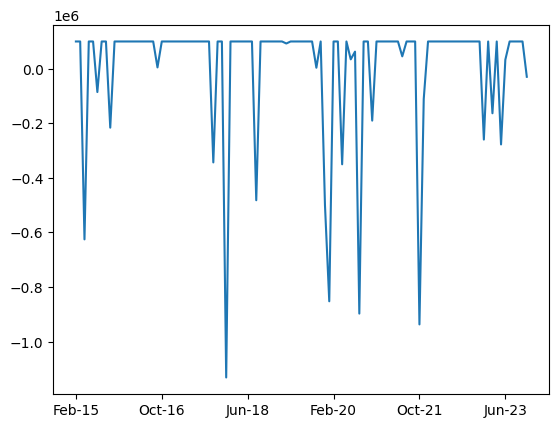

In [683]:
FINAL_P.Profit.plot()

In [392]:
(N.T @ pces).values.flatten()[0]

1000.0

In [604]:
N

,N
SPY,280.415477
AMZN,1892.923452
AAPL,1301.459187
TSLA,1298.163058
MSFT,1208.374556


In [359]:
pces

,Price
SPY,0.713227
AMZN,0.105657
AAPL,0.153674
TSLA,0.154064
MSFT,0.165512


In [339]:
pd.DataFrame.from_dict(N,orient='Index',columns=['N'])

,N
SPY,280.415477
AMZN,1892.923452
AAPL,1301.459187
TSLA,1298.163058
MSFT,1208.374556


In [336]:
N

{'SPY': 280.41547660525515,
 'AMZN': 1892.9234522132128,
 'AAPL': 1301.4591874789019,
 'TSLA': 1298.1630579021153,
 'MSFT': 1208.3745562579275}

In [328]:
200/pcar

array([ 280.41547661, 1892.92345221, 1301.45918748, 1298.1630579 ,
       1208.37455626])

In [291]:
prcsfeb.index[0]

Timestamp('2015-02-02 00:00:00')

In [265]:
firstfeb.iloc[0]['MSFT_Vol']

0.22637048

In [261]:
(monthend[0]-monthstart[0]).days/365

0.07397260273972603

In [182]:
FULLDF.loc[monthstart[0]:monthend[0]].index

DatetimeIndex(['2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05',
               '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-17', '2015-02-18',
               '2015-02-19', '2015-02-20', '2015-02-23', '2015-02-24',
               '2015-02-25', '2015-02-26', '2015-02-27'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
pricesmonth = prices.resample("M").last()
retsm = pricesmonth.pct_change().dropna()

In [ ]:
monthlyPF = portfolio_cmds.performanceMetrics(retsm,annualization=1)
styled_df = monthlyPF.style.format({
    'Mean': '{:,.2%}'.format,
    'Vol': '{:,.2%}'.format,
    'Sharpe': '{:,.3f}'.format,  # Use the appropriate format for Sharpe (e.g., six decimal places)
    'Min': '{:,.3%}'.format,
    'Max': '{:,.3%}'.format
})


# Monthly Returns Statistics 

- starting date: '2015-01-01'
- end date: '2023-12-19'


<style type="text/css">
</style>
<table id="T_b9a33">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_b9a33_level0_col0" class="col_heading level0 col0" >Mean</th>
      <th id="T_b9a33_level0_col1" class="col_heading level0 col1" >Vol</th>
      <th id="T_b9a33_level0_col2" class="col_heading level0 col2" >Sharpe</th>
      <th id="T_b9a33_level0_col3" class="col_heading level0 col3" >Min</th>
      <th id="T_b9a33_level0_col4" class="col_heading level0 col4" >Max</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_b9a33_level0_row0" class="row_heading level0 row0" >AAPL</th>
      <td id="T_b9a33_row0_col0" class="data row0 col0" >2.23%</td>
      <td id="T_b9a33_row0_col1" class="data row0 col1" >8.24%</td>
      <td id="T_b9a33_row0_col2" class="data row0 col2" >0.271</td>
      <td id="T_b9a33_row0_col3" class="data row0 col3" >-18.119%</td>
      <td id="T_b9a33_row0_col4" class="data row0 col4" >21.662%</td>
    </tr>
    <tr>
      <th id="T_b9a33_level0_row1" class="row_heading level0 row1" >AMZN</th>
      <td id="T_b9a33_row1_col0" class="data row1 col0" >2.45%</td>
      <td id="T_b9a33_row1_col1" class="data row1 col1" >9.14%</td>
      <td id="T_b9a33_row1_col2" class="data row1 col2" >0.267</td>
      <td id="T_b9a33_row1_col3" class="data row1 col3" >-23.753%</td>
      <td id="T_b9a33_row1_col4" class="data row1 col4" >27.060%</td>
    </tr>
    <tr>
      <th id="T_b9a33_level0_row2" class="row_heading level0 row2" >MSFT</th>
      <td id="T_b9a33_row2_col0" class="data row2 col0" >2.43%</td>
      <td id="T_b9a33_row2_col1" class="data row2 col1" >6.30%</td>
      <td id="T_b9a33_row2_col2" class="data row2 col2" >0.385</td>
      <td id="T_b9a33_row2_col3" class="data row2 col3" >-10.927%</td>
      <td id="T_b9a33_row2_col4" class="data row2 col4" >19.641%</td>
    </tr>
    <tr>
      <th id="T_b9a33_level0_row3" class="row_heading level0 row3" >SPY</th>
      <td id="T_b9a33_row3_col0" class="data row3 col0" >1.07%</td>
      <td id="T_b9a33_row3_col1" class="data row3 col1" >4.56%</td>
      <td id="T_b9a33_row3_col2" class="data row3 col2" >0.235</td>
      <td id="T_b9a33_row3_col3" class="data row3 col3" >-12.464%</td>
      <td id="T_b9a33_row3_col4" class="data row3 col4" >12.698%</td>
    </tr>
    <tr>
      <th id="T_b9a33_level0_row4" class="row_heading level0 row4" >TSLA</th>
      <td id="T_b9a33_row4_col0" class="data row4 col0" >4.26%</td>
      <td id="T_b9a33_row4_col1" class="data row4 col1" >18.20%</td>
      <td id="T_b9a33_row4_col2" class="data row4 col2" >0.234</td>
      <td id="T_b9a33_row4_col3" class="data row4 col3" >-36.733%</td>
      <td id="T_b9a33_row4_col4" class="data row4 col4" >74.145%</td>
    </tr>
    <tr>
      <th id="T_b9a33_level0_row5" class="row_heading level0 row5" >VIX</th>
      <td id="T_b9a33_row5_col0" class="data row5 col0" >3.02%</td>
      <td id="T_b9a33_row5_col1" class="data row5 col1" >29.11%</td>
      <td id="T_b9a33_row5_col2" class="data row5 col2" >0.104</td>
      <td id="T_b9a33_row5_col3" class="data row5 col3" >-45.897%</td>
      <td id="T_b9a33_row5_col4" class="data row5 col4" >134.571%</td>
    </tr>
  </tbody>
</table>

- Ignore the VIX return since its price level already represents the implied volatility of spy options expiring in thirty days. 

## Tail Metrics


<style type="text/css">
</style>
<table id="T_78cab">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_78cab_level0_col0" class="col_heading level0 col0" >Skewness</th>
      <th id="T_78cab_level0_col1" class="col_heading level0 col1" >Kurtosis</th>
      <th id="T_78cab_level0_col2" class="col_heading level0 col2" >VaR (0.05)</th>
      <th id="T_78cab_level0_col3" class="col_heading level0 col3" >CVaR (0.05)</th>
      <th id="T_78cab_level0_col4" class="col_heading level0 col4" >Max Drawdown</th>
      <th id="T_78cab_level0_col5" class="col_heading level0 col5" >Peak</th>
      <th id="T_78cab_level0_col6" class="col_heading level0 col6" >Bottom</th>
      <th id="T_78cab_level0_col7" class="col_heading level0 col7" >Recover</th>
      <th id="T_78cab_level0_col8" class="col_heading level0 col8" >Duration (to Recover)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_78cab_level0_row0" class="row_heading level0 row0" >AAPL</th>
      <td id="T_78cab_row0_col0" class="data row0 col0" >-0.074519</td>
      <td id="T_78cab_row0_col1" class="data row0 col1" >-0.518847</td>
      <td id="T_78cab_row0_col2" class="data row0 col2" >-11.61%</td>
      <td id="T_78cab_row0_col3" class="data row0 col3" >-13.42%</td>
      <td id="T_78cab_row0_col4" class="data row0 col4" >-30.46%</td>
      <td id="T_78cab_row0_col5" class="data row0 col5" >2018-08-31 00:00:00</td>
      <td id="T_78cab_row0_col6" class="data row0 col6" >2018-12-31 00:00:00</td>
      <td id="T_78cab_row0_col7" class="data row0 col7" >2019-10-31 00:00:00</td>
      <td id="T_78cab_row0_col8" class="data row0 col8" >426 days 00:00:00</td>
    </tr>
    <tr>
      <th id="T_78cab_level0_row1" class="row_heading level0 row1" >AMZN</th>
      <td id="T_78cab_row1_col0" class="data row1 col0" >0.256751</td>
      <td id="T_78cab_row1_col1" class="data row1 col1" >0.832292</td>
      <td id="T_78cab_row1_col2" class="data row1 col2" >-11.05%</td>
      <td id="T_78cab_row1_col3" class="data row1 col3" >-15.45%</td>
      <td id="T_78cab_row1_col4" class="data row1 col4" >-51.98%</td>
      <td id="T_78cab_row1_col5" class="data row1 col5" >2021-11-30 00:00:00</td>
      <td id="T_78cab_row1_col6" class="data row1 col6" >2022-12-31 00:00:00</td>
      <td id="T_78cab_row1_col7" class="data row1 col7" >NaT</td>
      <td id="T_78cab_row1_col8" class="data row1 col8" >NaT</td>
    </tr>
    <tr>
      <th id="T_78cab_level0_row2" class="row_heading level0 row2" >MSFT</th>
      <td id="T_78cab_row2_col0" class="data row2 col0" >0.256723</td>
      <td id="T_78cab_row2_col1" class="data row2 col1" >0.089905</td>
      <td id="T_78cab_row2_col2" class="data row2 col2" >-7.20%</td>
      <td id="T_78cab_row2_col3" class="data row2 col3" >-8.97%</td>
      <td id="T_78cab_row2_col4" class="data row2 col4" >-30.52%</td>
      <td id="T_78cab_row2_col5" class="data row2 col5" >2021-12-31 00:00:00</td>
      <td id="T_78cab_row2_col6" class="data row2 col6" >2022-10-31 00:00:00</td>
      <td id="T_78cab_row2_col7" class="data row2 col7" >2023-06-30 00:00:00</td>
      <td id="T_78cab_row2_col8" class="data row2 col8" >546 days 00:00:00</td>
    </tr>
    <tr>
      <th id="T_78cab_level0_row3" class="row_heading level0 row3" >SPY</th>
      <td id="T_78cab_row3_col0" class="data row3 col0" >-0.368433</td>
      <td id="T_78cab_row3_col1" class="data row3 col1" >0.432279</td>
      <td id="T_78cab_row3_col2" class="data row3 col2" >-7.61%</td>
      <td id="T_78cab_row3_col3" class="data row3 col3" >-9.24%</td>
      <td id="T_78cab_row3_col4" class="data row3 col4" >-23.93%</td>
      <td id="T_78cab_row3_col5" class="data row3 col5" >2021-12-31 00:00:00</td>
      <td id="T_78cab_row3_col6" class="data row3 col6" >2022-09-30 00:00:00</td>
      <td id="T_78cab_row3_col7" class="data row3 col7" >2023-12-31 00:00:00</td>
      <td id="T_78cab_row3_col8" class="data row3 col8" >730 days 00:00:00</td>
    </tr>
    <tr>
      <th id="T_78cab_level0_row4" class="row_heading level0 row4" >TSLA</th>
      <td id="T_78cab_row4_col0" class="data row4 col0" >1.015823</td>
      <td id="T_78cab_row4_col1" class="data row4 col1" >1.764821</td>
      <td id="T_78cab_row4_col2" class="data row4 col2" >-20.16%</td>
      <td id="T_78cab_row4_col3" class="data row4 col3" >-24.05%</td>
      <td id="T_78cab_row4_col4" class="data row4 col4" >-67.72%</td>
      <td id="T_78cab_row4_col5" class="data row4 col5" >2021-11-30 00:00:00</td>
      <td id="T_78cab_row4_col6" class="data row4 col6" >2022-12-31 00:00:00</td>
      <td id="T_78cab_row4_col7" class="data row4 col7" >NaT</td>
      <td id="T_78cab_row4_col8" class="data row4 col8" >NaT</td>
    </tr>
    <tr>
      <th id="T_78cab_level0_row5" class="row_heading level0 row5" >VIX</th>
      <td id="T_78cab_row5_col0" class="data row5 col0" >1.625448</td>
      <td id="T_78cab_row5_col1" class="data row5 col1" >4.653862</td>
      <td id="T_78cab_row5_col2" class="data row5 col2" >-34.43%</td>
      <td id="T_78cab_row5_col3" class="data row5 col3" >-38.08%</td>
      <td id="T_78cab_row5_col4" class="data row5 col4" >-76.60%</td>
      <td id="T_78cab_row5_col5" class="data row5 col5" >2020-03-31 00:00:00</td>
      <td id="T_78cab_row5_col6" class="data row5 col6" >2023-12-31 00:00:00</td>
      <td id="T_78cab_row5_col7" class="data row5 col7" >NaT</td>
      <td id="T_78cab_row5_col8" class="data row5 col8" >NaT</td>
    </tr>
  </tbody>
</table>


In [ ]:
tailmetrics = portfolio_cmds.tailMetrics(returns=retsm)
tailmetrics
tailmetrics_style = tailmetrics.style.format({"VaR (0.05)":"{:,.2%}",'CVaR (0.05)':"{:,.2%}","Max Drawdown":"{:,.2%}"})
print(tailmetrics_style.to_html())

In [468]:
c1.K = 20

In [482]:
k1 = 40
T1 = 1/12
s1 = 35.82
sig1 = .22
r1 = .0001
T2 = (1/12)-1/365
c1 = CALL(S0=s1, K= k1, R = r1,Sigma=sig1,T = T1)
c1.update_T(new_T=T2)
callE = Option_Pricer(contract=c1)

callE.return_values()

,Price,Delta,Gamma,Vega,Theta
CALL(K = 40),0.036634,0.041294,0.039528,0.899239,-0.003363


In [516]:
callE.delta()

0.04129421492096203

In [431]:
[i for i in dir(c1) if 'update' in i]

['update_T', 'update_iv', 'update_rf', 'update_spot']

In [255]:
prices.tail()

,AAPL,AMZN,MSFT,SPY,TSLA,VIX
2023-12-13,197.96,148.84,374.37,468.596904,239.29,12.19
2023-12-14,198.11,147.42,365.93,470.100797,251.05,12.48
2023-12-15,197.57,149.97,370.73,469.330000,253.50,12.28
2023-12-18,195.89,154.07,372.65,471.970000,252.08,12.56
2023-12-19,196.94,153.79,373.26,474.840000,257.22,12.53


In [254]:
FULLDF.tail(1)

,AAPL,AMZN,MSFT,SPY,TSLA,MSFT_Vol,TSLA_Vol,AAPL_Vol,AMZN_Vol,SPY_Vol,VIX_Vol,ONE_M
2023-12-19,0.00536,-0.001817,0.001637,0.006081,0.02039,0.192367,0.429326,0.159047,0.239435,0.105597,0.1253,0.0551


In [202]:
callE.price_derivative()

0.046382650499247946

In [223]:
Ts = np.array(sorted([i/365 for i in range(0,31)],reverse=True))
k1 = 40
T1 = 1/12
s1 = 35.82
sig1 = 0.2263
r1 = .0001
callE = Option_Pricer(CALL(S0=s1, K= k1, R = r1,Sigma=sig1,T = Ts))
callE.price_derivative()

array([4.47719633e-02, 4.09930499e-02, 3.73418614e-02, 3.38251395e-02,
       3.04498309e-02, 2.72230522e-02, 2.41520404e-02, 2.12440857e-02,
       1.85064423e-02, 1.59462112e-02, 1.35701895e-02, 1.13846761e-02,
       9.39522884e-03, 7.60635976e-03, 6.02116201e-03, 4.64085977e-03,
       3.46427920e-03, 2.48724846e-03, 1.70195469e-03, 1.09631932e-03,
       6.53507183e-04, 3.51763465e-04, 1.64869227e-04, 6.35828841e-05,
       1.83785836e-05, 3.37170162e-06, 2.82551834e-07, 5.06347752e-09,
       2.04459363e-12, 2.78936834e-22, 0.00000000e+00])